In [1]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm

In [205]:
### DATA
from data_loader import df_consumption, joiner_official, merge6

In [206]:
df_master= merge6
df_master.columns

Index(['country_a', 'country_b', 'year', 'a_name', 'b_name', 'imports',
       'exports', 'iso_code_a', 'iso_code_b', 'co2', 'consumption_co2',
       'population', 'gdp', 'co2_b', 'consumption_co2_b', 'population_b',
       'gdp_b', 'imports_a', 'exports_a', 'imports_b', 'exports_b'],
      dtype='object')

In [207]:
paris= pd.read_csv('data/paris.csv')
paris= paris.rename(columns={'base year': 'year'})
paris.dropna(inplace=True)
paris['year']= paris['year'].astype(int)                  
df_paris = pd.merge(paris,df_consumption[['iso_code','year','consumption_co2']],'left',left_on=(['iso_code','year']),right_on=(['iso_code','year']))
df_paris= df_paris.rename(columns={'iso_code': 'iso_code_a'})
df_paris['reduction high']= df_paris['reduction high'].str.rstrip('%').astype('float') / 100.0
# Compute emissions goal for the selected countries
df_paris['Emissions_goal']= df_paris['consumption_co2']*(1-df_paris['reduction high'])

df_paris

,Unnamed: 0,country,iso_code_a,year,target year,reduction low,reduction high,priority_group,consumption_co2,Emissions_goal
0,0,China,CHN,2005,2030.0,20%,0.20,1,4822.978,3858.38240
1,1,USA,USA,2005,2025.0,26%,0.28,1,6547.818,4714.42896
2,2,Austria,AUT,1990,2030.0,40%,0.40,2,82.531,49.51860
3,3,Belgium,BEL,1990,2030.0,40%,0.40,2,147.260,88.35600
4,4,Bulgaria,BGR,1990,2030.0,40%,0.40,2,56.052,33.63120
5,5,Croatia,HRV,1990,2030.0,40%,0.40,2,20.543,12.32580
6,6,Republic of Cyprus,CYP,1990,2030.0,40%,0.40,2,5.784,3.47040
7,7,Czech Republic,CZE,1990,2030.0,40%,0.40,2,163.037,97.82220
8,8,Denmark,DNK,1990,2030.0,40%,0.40,2,57.452,34.47120
9,9,Estonia,EST,1990,2030.0,40%,0.40,2,31.784,19.07040


In [208]:
# Join df_master and paris data
df_master = df_master[(df_master.gdp.notnull())]
df_master['gdp']= df_master['gdp']/1000000 # GDP in millon dollars
df = pd.merge(df_master,df_paris[['iso_code_a','Emissions_goal','priority_group']],'left',on=['iso_code_a'])
df = df.loc[df.consumption_co2.notnull()]

In [209]:
# COLUMNS NEEDED:
# group - GDP/Cap
df['gdp_percap'] = df.apply(lambda row: row['gdp'] / row['population'], axis=1)
# consumption-based emissions per capita
df.rename(columns = {'consumption_co2':'consumption'}, inplace=True)
df['consumption_percap'] = df['consumption']*1000000000000 / df['population']
df['consumption_goal'] = df['Emissions_goal']*1000000000000 / df['population']

# import_share
df['imports_share'] = df.apply(lambda row: row['imports'] / row['imports_a'], axis=1)

# Marginal propensity of external consumption or total Imports: M/GDP
df['Mg_ImportsTot'] = df['imports_a']/df['gdp']

# Marginal propensity of imports for each trade partner
df['MgM_bilateral'] = df['imports']*100/df['gdp']


In [210]:
# Growth variables
growth= df[['country_a', 'iso_code_a','year','gdp','imports_a','Mg_ImportsTot','consumption_percap','population']]
growth= growth.drop_duplicates(subset=['iso_code_a', 'year'], keep='last') #get aggregates by country-year
growth

,country_a,iso_code_a,year,gdp,imports_a,Mg_ImportsTot,consumption_percap,population
1954,2,USA,1997,11400000.0,885651.80,0.077689,2.096607e+07,271713984.0
1955,2,USA,1998,11900000.0,933155.60,0.078416,2.125665e+07,275175008.0
1956,2,USA,1999,12500000.0,1032958.60,0.082637,2.166079e+07,278548000.0
1957,2,USA,2000,13000000.0,1216111.50,0.093547,2.219898e+07,281711008.0
1958,2,USA,2001,13100000.0,1158994.90,0.088473,2.166241e+07,284608000.0
...,...,...,...,...,...,...,...,...
105920,900,AUS,2009,927000.0,5765.09,0.006219,1.725341e+07,21751000.0
105921,900,AUS,2010,994000.0,7298.35,0.007342,1.730571e+07,22155000.0
105922,900,AUS,2011,1030000.0,8619.08,0.008368,1.732057e+07,22538000.0
105923,900,AUS,2012,1020000.0,8282.99,0.008121,1.748271e+07,22904000.0


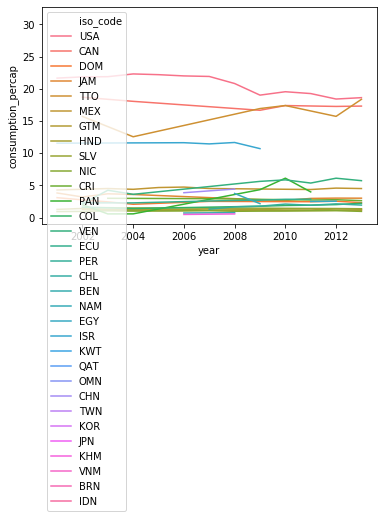

In [38]:
# Plot consumption percapita over time
sns.lineplot(x="year", y="consumption_percap",hue="iso_code", data=growth[growth['community']==1])

In [211]:
#compute variation rates of GDP, MgC_imports, and consumption_percap for each year
growth = growth[growth['year']>= 2000]
# compute lagged variables
growth['gdp_lag'] = growth.groupby(['iso_code_a'])['gdp'].shift(1)
growth['MgM_lag'] = growth.groupby(['iso_code_a'])['Mg_ImportsTot'].shift(1)
growth['consump_lag'] = growth.groupby(['iso_code_a'])['consumption_percap'].shift(1)
growth = growth.loc[growth['gdp_lag'].notnull()]

# compute variation rates 
growth['gdp_var']= (growth['gdp']- growth['gdp_lag'])/growth['gdp_lag']
growth['MgM_var']= (growth['Mg_ImportsTot']- growth['MgM_lag'])/growth['MgM_lag']
growth['consump_var']= (growth['consumption_percap']- growth['consump_lag'])/growth['consump_lag']


# Dataframe with growth rates  per country
#Take average growth rates per country
df_growth = growth[['iso_code_a','gdp_var','MgM_var','consump_var']].groupby(['iso_code_a']).agg({'gdp_var':'mean','MgM_var':'mean','consump_var':'mean'}).reset_index()

df_growth

/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,iso_code_a,gdp_var,MgM_var,consump_var
0,ALB,0.049885,0.074058,0.044282
1,ARE,0.058557,0.163558,-0.010991
2,ARG,0.035705,0.102923,0.026249
3,ARM,0.080221,0.103865,0.048360
4,AUS,0.031253,0.054881,0.010290
...,...,...,...,...
111,VEN,0.092775,0.076904,0.118306
112,VNM,0.078903,0.048749,0.100951
113,ZAF,0.039587,0.104843,0.012465
114,ZMB,0.120583,0.050405,0.028435


In [212]:
# Use growth dataframe to compute parameters for the model Consumption ~ B0+ B1*C_t-1 + B2*GDP + B3*Imports
# get list of countries
list_countries= growth['iso_code_a'].unique()

# Iterate over each country
dict_results={}
for country in list_countries.tolist():
    df_country= growth[growth['iso_code_a']== country]
    X= df_country[['consump_lag','gdp','imports_a']]
    Y= df_country['consumption_percap']
    result = sm.ols(formula="Y ~ X", data=df_country, missing='drop').fit()
    dict_results.setdefault('iso_code_a',[]).append(country)
    dict_results.setdefault('beta0',[]).append(result.params[0]) # Intercept
    dict_results.setdefault('beta1',[]).append(result.params[1]) # Consumption Lag to account for autocorrelation
    dict_results.setdefault('beta2',[]).append(result.params[2]) # Mg propensity GDP
    dict_results.setdefault('beta3',[]).append(result.params[3]) # Mg propensity Imports

    #dic_results.setdefault('resid',[]).append(np.mean(result.resid)) #Residuals

In [213]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     16.51
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           0.000530
Time:                        23:38:18   Log-Likelihood:                -185.03
No. Observations:                  13   AIC:                             378.1
Df Residuals:                       9   BIC:                             380.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.036e+06   4.36e+06      0.467      0.652   -7.83e+06    1.19e+07
X[0]           1.0001      0.438      2.284      0.048       0.010       1.991
X[1]          -2.2233      8.203     -0.271      0.792     -20.779      16.332
X[2]          11.0739    363.881      0.030      0.976    -812.083     834.230
==============================================================================
Omnibus:                        8.510   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                4.503
Skew:                          -1.314   Prob(JB):                        0.105
Kurtosis:                       4.187   Cond. No.                     5.83e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [214]:
# Convert dictionary with parameters to dataframe
df_params= pd.DataFrame.from_dict(dict_results)

## Merge computed parameters in the main dataframe
df= pd.merge(df, df_growth, on=['iso_code_a'], how='inner') #add annual variation rates
df= pd.merge(df, df_params, on=['iso_code_a'], how='inner') #add annual variation rates

In [215]:
df['GDP-X']= df['gdp']-df['exports_a']

In [216]:
# Filter year 2000 
df2000= df[df['year']==2000]

## Dynamic Model

In [217]:
# Dataframe at the country level to define node attributes
nodes= df2000.drop_duplicates(subset=['country_a'], keep='first')
nodes= nodes.round(3)
df2000= df2000.round(3)

In [218]:
# Paris agreement priority groups
nodes['priority_group']= nodes['priority_group'].replace(np.nan, 0)

In [219]:
# Classify countries in four groups by GDP
nodes= nodes.sort_values(by=['gdp_percap'], ascending=False).reset_index(drop=True)
nodes['index1']=nodes.index
def classif(r):
    if r< 20:
        m= '1'
    elif r>=20 and r<60:
        m= '2'
    elif r>=60 and r<100:
        m= '3'
    elif r>= 100:
        m= '4'
    return m
nodes['group'] = nodes.index1.apply(classif)

In [221]:
nodes['priority_group'].value_counts()

0.0    81
2.0    28
1.0     7
Name: priority_group, dtype: int64

In [222]:
def initialize():
    global G, nextg, pos
    # Create graph with edge attributes: Imports, parteners_consumption, and Imports growth rate= alpha
    G = nx.from_pandas_edgelist(df2000[['country_a','country_b','imports','exports','MgM_bilateral','MgM_var']], 'country_a', 'country_b', 
                                edge_attr=['imports','exports','MgM_bilateral','MgM_var'], create_using= nx.MultiDiGraph())
        # set graph layout
    pos = nx.spring_layout(G)
        # convert dataframe to dictionary of attributes
    node_attr = nodes[['country_a','exports_a','imports_a','GDP-X','gdp_var','consumption_percap','beta0','beta1','beta2','beta3','priority_group']].set_index('country_a').to_dict('index')
    nx.set_node_attributes(G, node_attr)
    
    # remove imbalanced node
    G.remove_node(920)
    
    nextg= G.copy()

In [203]:
#initialize()
#for i, data in nextg.nodes.data():
    #print(nextg.nodes(data=True))

In [204]:
#for i, j, data in nextg.edges.data():
    #print(nextg.edges(data=True))
    #break

In [238]:
def update():
    global G, nextg

    # Update GDP with GDP growth rate
    for i in G.nodes():
        try:
            nextg.nodes[i]['GDP'] = (1+ G.nodes[i]['gdp_var'])* (G.nodes[i]['GDP-X'] + G.nodes[i]['exports_a'])
        except:
            continue
        
    # Update GDP without exports
    
    for i in G.nodes():
        try:
            nextg.nodes[i]['GDP-X'] = (1+ G.nodes[i]['gdp_var'])* G.nodes[i]['GDP-X']
        except:
            continue
    
    # Update propensity rate variation 
    
    #for i, j, k, weight in nextg.edges(data="weight", keys=True): 
        #if nextg.nodes[i]['priority_group']!= 0:
            #nextg[i][j][0]['MgM_var']= -0.5
    
    
    # Update Imports variation at edge level
    
    for i, j, k, weight in nextg.edges(data="weight", keys=True): 
        
        nextg[i][j][0]['imports']= (1 + nextg.edges[i,j,0]['MgM_var'])* (nextg.edges[i,j,0]['MgM_bilateral']/100)* nextg.nodes[i]['GDP']
        

    # Get total imports
    
    for i in nextg.nodes(): 
        nextg.nodes[i]['imports_a'] = nextg.out_degree(i,'imports')
    
    # Update bilateral exports based on updated bilateral imports:
    
    for i, j, k, weight in nextg.edges(data="weight", keys=True): 
        g= nextg[i][j][0]['imports']
        for j, y, z, w in nextg.edges(data="weight", keys=True):
            if y == i:
                nextg[j][y][0]['exports'] = g
            else:
                continue
     
    # Compute total exports
    for i in nextg.nodes(): 
        nextg.nodes[i]['exports_a'] = nextg.out_degree(i,'exports')
 
    
    # Compute consumption-based emissions at node level
    for i in nextg.nodes():
        try:
            nextg.nodes[i]['consumption_percap']= nextg.nodes[i]['beta0'] + nextg.nodes[i]['beta1']*G.nodes[i]['consumption_percap'] + nextg.nodes[i]['beta2']*nextg.nodes[i]['GDP'] + nextg.nodes[i]['beta3']*nextg.nodes[i]['imports_a']   
        except:
            nextg.nodes[i]['consumption_percap']=0
            
    G= nextg.copy()


In [197]:
def emissions_trend():
    global nextg
    high_income=0
    uppermiddle_income= 0
    lowermiddle_income= 0
    low_income= 0
    for i in nextg.nodes():
        if nextg.nodes[i]['group']=='1':
            high_income+= nextg.nodes[i]['consumption_percap']
        elif nextg.nodes[i]['group']=='2':
            uppermiddle_income+= nextg.nodes[i]['consumption_percap']
        elif nextg.nodes[i]['group']=='3':
            lowermiddle_income+= nextg.nodes[i]['consumption_percap']
        else:
            low_income+= nextg.nodes[i]['consumption_percap']
    return high_income, uppermiddle_income, lowermiddle_income, low_income

In [239]:
def priority_groups_trend():
    global nextg
    high_priority=0
    low_priority= 0

    for i in nextg.nodes():
        if nextg.nodes[i]['priority_group']==1.0 or nextg.nodes[i]['priority_group']== 2.0:
            high_priority+= nextg.nodes[i]['consumption_percap']
        elif nextg.nodes[i]['priority_group']==0:
            low_priority+= nextg.nodes[i]['consumption_percap']

    return high_priority, low_priority

### Simulations by income-level groups

In [198]:
N= 20
initialize()
emissions_high=[]
emissions_middleUpper=[]
emissions_middleLower=[]
emissions_low=[]

for i in range(N):
    update()
    H, U, M, L = emissions_trend() # Get consumption by groups at the end of period
    emissions_high.append(H) # array of total consumption for high income countries
    emissions_middleUpper.append(U) # array of total consumption for middle income countries
    emissions_middleLower.append(M)
    emissions_low.append(L) # array of total consumption for middle income countries
        
    

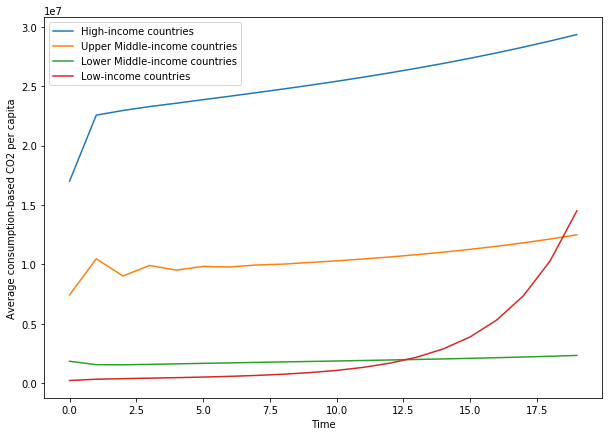

In [202]:
plt.figure(figsize=(10,7))
plt.plot(range(N),[x / 20 for x in emissions_high], label='High-income countries')
plt.plot(range(N),[x / 40 for x in emissions_middleUpper], label='Upper Middle-income countries')
plt.plot(range(N),[x / 40 for x in emissions_middleLower], label='Lower Middle-income countries')
plt.plot(range(N),[x / 16 for x in emissions_low], label='Low-income countries')

plt.xlabel('Time')
plt.ylabel('Average consumption-based CO2 per capita')
plt.legend()

### Simulations by group priority

In [240]:
N= 25
initialize()
emissions_highprio=[]
emissions_lowprio=[]


for i in range(N):
    update()
    X,Y = priority_groups_trend() # Get consumption by groups at the end of period
    emissions_highprio.append(X) # array of total consumption for high priority countries
    emissions_lowprio.append(Y) # array of total consumption for low countries
        
    

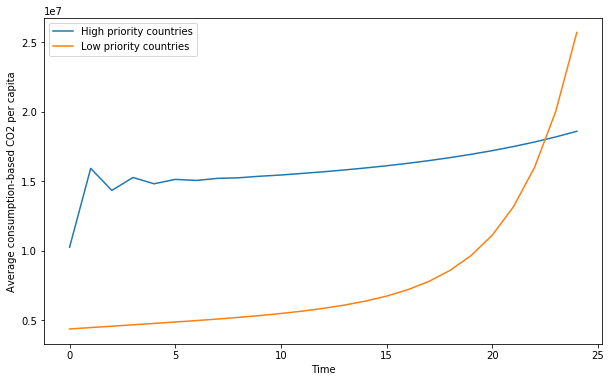

In [242]:
plt.figure(figsize=(10,6))
plt.plot(range(N),[x / 35 for x in emissions_highprio], label='High priority countries')
plt.plot(range(N),[x / 81 for x in emissions_lowprio], label='Low priority countries')

plt.xlabel('Time')
plt.ylabel('Average consumption-based CO2 per capita')
plt.legend()